In [1]:
#Import needed libraries
import pandas as pd
import numpy as np
import scipy
import scipy.stats
import random
import os
import pickle
import theano
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.cuda as cuda
import matplotlib.pyplot as plt
from skorch.net import NeuralNetClassifier
import torch.utils.data as Data

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# CUDA initializing
We want to build a device-agnostic code. </br>
- using the documentation: https://pytorch.org/docs/master/notes/cuda.html
- requires to run argparse : see tutorial https://docs.python.org/2/howto/argparse.html (I understand what it does now — don't think it's super useful)
- 

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # If CUDA is available => cuda:0 prints
print(device)

cuda:0


# Import data

In [3]:
# Buid the feature matrix
data = pd.read_csv('/home/xsong/Alma/2017---Deep-learning-yeast-UTRs/Data/Random_UTRs.csv')

In [16]:
print(data.shape())

TypeError: 'tuple' object is not callable

## One-hot encoding of the sequences.

i.e. we're converting the sequences from being represented as a 50 character string of bases to a 4x50 matrix of 1's and 0's, with each row corresponding to a base and every column a position in the UTR.

In [4]:
# From the work of Cuperus et al.
# one hot encoding of UTRs
# X = one hot encoding matrix
# Y = growth rates

def one_hot_encoding(df, seq_column, expression):

    bases = ['A','C','G','T']
    base_dict = dict(zip(bases,range(4))) # {'A' : 0, 'C' : 1, 'G' : 2, 'T' : 3}

    n = len(df)
    
    # length of the UTR sequence
    # we also add 10 empty spaces to either side
    total_width = df[seq_column].str.len().max() + 20
    
    # initialize an empty numpy ndarray of the appropriate size
    X = np.zeros((n, 1, 4, total_width))
    
    # an array with the sequences that we will one-hot encode
    seqs = df[seq_column].values
    
    # loop through the array of sequences to create an array that keras will actually read
    for i in range(n):
        seq = seqs[i]
        
        # loop through each individual sequence, from the 5' to 3' end
        for b in range(len(seq)):
            # this will assign a 1 to the appropriate base and position for this UTR sequence
            X[i, 0, base_dict[seq[b]], int(b + round((total_width - len(seq))/2.))] = 1.
    
        # keep track of where we are
        if (i%100000)==0:
            print(i),
        
    X = X.astype(theano.config.floatX)
    Y = np.array(df[expression].values,
                   dtype = theano.config.floatX)[:, np.newaxis]
    
    return X, Y, total_width

In [5]:
X, Y, total_width = one_hot_encoding(data, 'UTR', 'growth_rate')

0
100000
200000
300000
400000


In [21]:
print(X.shape)

(489348, 1, 4, 70)


In [6]:
X_torch = torch.from_numpy(X).float().cuda() #change to torch and upload to CUDA
Y_torch = torch.from_numpy(Y).float().cuda() #change to torch and upload to CUDA

In [18]:
print(X_torch)

KeyboardInterrupt: 

## Generate different data sets

In [7]:
# a sorted numpy array of UTR indexes, from least reads to most reads
sorted_inds = data.sort_values('t0').index.values
train_inds = sorted_inds[:int(0.95*len(sorted_inds))] # 95% of the data as the training set
test_inds = sorted_inds[int(0.95*len(sorted_inds)):] # UTRs with most reads at time point 0 as the test set

# set the seed before randomly shuffling the data
seed = 0.5
random.shuffle(train_inds, lambda :seed)

# Generate Model

I need to figure out how to make the dropout happen and Flatten. 
How do hidden units work in fully connected layers?

## Buid the neural network

In [8]:
size=1
batch_size=10
class Net(nn.Module):
    def __init__(self, x):
        super(Net, self).__init__()
        # input channel, output channels = number of filters, convolution kernel size
        # kernel
        self.conv1 = nn.Conv2d(1, size, [4,13])
        self.conv2 = nn.Conv2d(1, size, [1,13])
        self.conv3 = nn.Conv2d(1, size, [1,13])
        self.fc1 = nn.Linear(34, 120)
        self.lin_out1 = nn.Linear(120, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        #print('conv1',x.size())
        x = F.relu(self.conv2(x))
        #print('conv2',x.size())
        x = F.relu(self.conv3(x))
        #print('conv3',x.size())
        x = F.relu(self.fc1(x))
        #print('fc1',x.size())
        x = self.lin_out1(x)
        #print('lol1',x.size())
        #x = nn.Dropout(p=0.15)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

net = Net(data)
net = net.to(device)
print(net)
next(net.parameters()).is_cuda

Net(
  (conv1): Conv2d(1, 1, kernel_size=[4, 13], stride=(1, 1))
  (conv2): Conv2d(1, 1, kernel_size=[1, 13], stride=(1, 1))
  (conv3): Conv2d(1, 1, kernel_size=[1, 13], stride=(1, 1))
  (fc1): Linear(in_features=34, out_features=120, bias=True)
  (lin_out1): Linear(in_features=120, out_features=1, bias=True)
)


True

In [9]:
params = list(net.parameters())
print(len(params))
print(params[0].size()) 

10
torch.Size([1, 1, 4, 13])


## Training & Cross Validation


In [10]:
def eval(net, data):
        net.eval()
        ######EVALUATION STEP#################
        #same as during training step, need to do batch training
        correct_count = 0.
        total_count = 0.
        for i, (dev_data_x,dev_data_y) in enumerate(dev_loader):
            dev_data_y.requires_grad=False
            dev_data_y = dev_data_y[:,0]   # resize the value as vector
            pred = net(dev_data_x)
            pred = pred[:,0,0,0]   #resize the output as vector
            fit= loss_func(pred, dev_data_y)
        return loss

In [11]:
# Choice of optimizer & loss function => MSE 
# Using backpropagation

# Initiate the hyperparameters
number_epochs = 20
track_loss = []
loss_func = nn.MSELoss().cuda()
k_fold = 10

# Define dataset and initialize mini-batch data
x = X_torch[train_inds]
y = Y_torch[train_inds]
num_data = x.shape[0]
num_dev_data = int(num_data/k_fold) #evalutation data amount
fit_store = np.tile(0,(k_fold,number_epochs))
fit_store = torch.from_numpy(fit_store).float().cuda()

print(num_data - num_dev_data, num_dev_data)

418392 46488


In [28]:
num_data/128

3631.875

In [12]:
#Training with crossvalidation
for split in range(k_fold):
    train_index = np.empty
    dev_index = np.empty
    dev_index = list(range(num_dev_data*split, num_dev_data*(split+1)))
    if split == 0:
        train_index = np.array(range(num_dev_data*(split+1),num_dev_data*k_fold))
    else:
        train_index = np.array(range(0, num_dev_data*split))
        train_index = np.append(train_index, np.array(range(num_dev_data*(split+1),num_dev_data*k_fold)))
        
    dev_data_x = x[dev_index]      #evalutation data
    dev_data_y = y[dev_index]      #evalutation data

    train_data_x = x[train_index]
    train_data_y = y[train_index]
    
    train_dataset = Data.TensorDataset(train_data_x, train_data_y)
    train_loader = Data.DataLoader(train_dataset, batch_size=128, shuffle=True)
    
    dev_dataset = Data.TensorDataset(dev_data_x, dev_data_y)
    dev_loader = Data.DataLoader(dev_dataset, batch_size=128, shuffle=True)  
    
    learning_rate = 0.005
    running_loss = 0.
    best_fit = 10
    optimizer = torch.optim.Adam(net.parameters(), learning_rate)

    for epoch in range(number_epochs): # loop over the dataset multiple time        
        #######TRAINING STEP##################
        j=1
        for i, (train_data_x,train_data_y) in enumerate(train_loader):
            train_data_y.requires_grad=False
            train_data_y = train_data_y[:,0].float()                 # resize the value as vector
            optimizer.zero_grad()      # zero the parameter gradients
            output = net(train_data_x)
            output = output[:,0,0,0]   #resize the output as vector
            loss = loss_func(output, train_data_y)# compute the loss of the system
            loss.backward()            # start backward function
            optimizer.step()           # optimizing step
            running_loss += loss.item()
            if ((i+1)%1000)==0:
                print(epoch+1, i+1 ,running_loss / 1000)
                track_loss.append(running_loss / 1000)
                running_loss=0.
        fit = eval(net, dev_data_x)
        fit_store[split,epoch]=fit
        print(epoch+1,fit[0])
        if fit<best_fit:
            best_fit = fit
            print("SAVE FILE AS Model_training_28-06-18_" + str(split+1) + "_" + str(epoch+1))
            torch.save(net.state_dict(),"/home/xsong/Alma/Training/Model_training_01-07-18_" + str(split+1) + "_" + str(epoch+1) + ".pt")
        else:
            learning_rate *= 0.8
            optimizer = torch.optim.Adam(net.parameters(), learning_rate)
print('Finished Training')

1 1000 1.2324407572746277
1 2000 1.1855097497105598
1 3000 1.1755826026797294


/home/xsong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


1 tensor(1.0039, device='cuda:0')
SAVE FILE AS Model_training_28-06-18_1_1
2 1000 1.47247722363472
2 2000 1.158309293448925
2 3000 1.1551016172170638
2 tensor(1.1533, device='cuda:0')
3 1000 1.4560440230965614
3 2000 1.1507408239841461
3 3000 1.145461803138256
3 tensor(1.2602, device='cuda:0')
4 1000 1.456721633195877
4 2000 1.1479868300557137
4 3000 1.1388120423555375
4 tensor(0.9070, device='cuda:0')
SAVE FILE AS Model_training_28-06-18_1_4
5 1000 1.4532001731991768
5 2000 1.1383193391561508
5 3000 1.1372029576897622
5 tensor(1.2961, device='cuda:0')
6 1000 1.4426856991648673
6 2000 1.138196913421154
6 3000 1.1356974898576737
6 tensor(1.0871, device='cuda:0')
7 1000 1.4372219128012658
7 2000 1.133428248822689
7 3000 1.141869734466076
7 tensor(1.2000, device='cuda:0')
8 1000 1.443699648320675
8 2000 1.1359167637825012
8 3000 1.1278111726045608
8 tensor(1.1014, device='cuda:0')
9 1000 1.4383499640226365
9 2000 1.1358043676018714
9 3000 1.1238628831505775
9 tensor(1.3782, device='cuda:0

9 3000 1.107047669649124
9 tensor(1.1062, device='cuda:0')
10 1000 1.3981898968219757
10 2000 1.1060370069742202
10 3000 1.1068423251509667
10 tensor(1.0751, device='cuda:0')
11 1000 1.4065151560902596
11 2000 1.1049822229743005
11 3000 1.1055225154161454
11 tensor(1.3058, device='cuda:0')
12 1000 1.399225634098053
12 2000 1.1022388268709182
12 3000 1.1057702408432961
12 tensor(0.9568, device='cuda:0')
SAVE FILE AS Model_training_28-06-18_4_12
13 1000 1.4030533627867698
13 2000 1.0963409792780876
13 3000 1.1101109374761582
13 tensor(1.3113, device='cuda:0')
14 1000 1.3958540444970131
14 2000 1.1071608418226242
14 3000 1.1052333427071572
14 tensor(0.8605, device='cuda:0')
SAVE FILE AS Model_training_28-06-18_4_14
15 1000 1.3955431810021401
15 2000 1.107454279780388
15 3000 1.1051820206642151
15 tensor(1.1582, device='cuda:0')
16 1000 1.4005523637533188
16 2000 1.1044680505990982
16 3000 1.0977853132486344
16 tensor(1.2208, device='cuda:0')
17 1000 1.4019946308732032
17 2000 1.0995208890

15 1000 1.4038971851468087
15 2000 1.108886981010437
15 3000 1.1020218552947045
15 tensor(1.0776, device='cuda:0')
16 1000 1.4045476962924004
16 2000 1.1039492826461792
16 3000 1.1063581923246384
16 tensor(0.9327, device='cuda:0')
SAVE FILE AS Model_training_28-06-18_7_16
17 1000 1.4010173364281655
17 2000 1.108018521487713
17 3000 1.107896510720253
17 tensor(1.1004, device='cuda:0')
18 1000 1.4026926478743553
18 2000 1.1030774031281472
18 3000 1.1077611054778098
18 tensor(1.0408, device='cuda:0')
19 1000 1.4002632336616516
19 2000 1.1042405482530593
19 3000 1.1023809323310851
19 tensor(0.8783, device='cuda:0')
SAVE FILE AS Model_training_28-06-18_7_19
20 1000 1.404326493382454
20 2000 1.103686425447464
20 3000 1.1062701397538186
20 tensor(1.0188, device='cuda:0')
1 1000 1.1256383127570153
1 2000 1.1232905502319337
1 3000 1.1263217490315438
1 tensor(1.1985, device='cuda:0')
SAVE FILE AS Model_training_28-06-18_8_1
2 1000 1.431370835840702
2 2000 1.1164321351647377
2 3000 1.122936863601

[[1.0038807  1.153343   1.2601599  0.90704477 1.296137   1.0871205
  1.2000172  1.1014447  1.3782322  1.2029636  0.8118139  1.1812987
  1.0521337  0.9938978  1.2050545  1.0945481  1.0731126  1.0322701
  1.3863508  0.81264424]
 [1.1695133  1.0590678  0.90998197 1.2534696  1.4097251  1.1801715
  0.974822   1.0856262  1.1307346  1.2615625  1.1041299  1.1421175
  1.4186667  1.012886   1.3412457  0.82913584 1.3270711  0.9195143
  1.3248733  1.2388452 ]
 [1.0567124  1.3418034  0.79398656 0.73711914 1.1605332  1.0050591
  1.3737319  1.1966586  1.0869043  0.9843082  1.2390984  1.2984054
  1.4427743  0.8318581  1.0929902  1.0137036  1.0700717  1.027095
  1.3045512  1.2497848 ]
 [1.150658   1.0007927  1.029404   1.1017896  1.3266059  1.1685586
  1.2466583  0.98317486 1.1062446  1.0751096  1.3057927  0.9568088
  1.3112824  0.8604887  1.1582496  1.2208452  0.98920363 1.3205733
  1.2393444  0.8601665 ]
 [1.3276137  1.4578547  1.0317829  0.92605174 0.9086044  1.411937
  0.92999476 1.0800868  1.19359

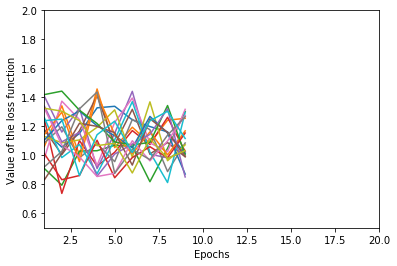

In [103]:
# Plotting of the loss function
time = np.array(range(0, number_epochs))
time = np.tile(time, (10,1))
fit_plot = fit_store.data.cpu().numpy()
print(fit_plot)
plt.plot(fit_plot)
plt.axis([1,20, 0.5, 2])

plt.ylabel('Value of the loss function')
plt.xlabel('Epochs')
plt.show()


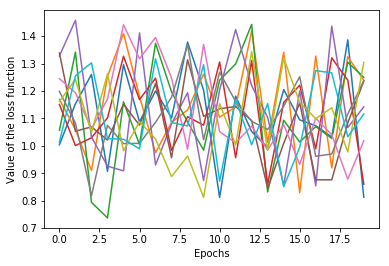

In [111]:
plt.plot(fit_plot_t)
plt.ylabel('Value of the loss function')
plt.xlabel('Epochs')
#plt.show()
plt.savefig("/home/xsong/Desktop/test_loss.png", dpi = 300)

In [50]:
(1.23+1.18+1.17)/3

1.1933333333333334

In [60]:
## reorganize running_loss function
loss_plot = np.reshape(track_loss, (200,3))
loss_mean = loss_plot.mean(axis=1)
print(loss_mean)
loss_mean = np.reshape(loss_mean,(10,20))
loss_mean = np.transpose(loss_mean)
print(loss_mean)

[1.19784437 1.26196271 1.25074888 1.24784017 1.24290749 1.23886003
 1.23750663 1.23580919 1.2326724  1.23320334 1.23082867 1.23100003
 1.23142065 1.22663594 1.23039798 1.22673987 1.22791398 1.22789544
 1.22682644 1.22521046 1.123271   1.22187799 1.22393161 1.22221253
 1.22115662 1.21617234 1.21457285 1.21248398 1.20943891 1.20946201
 1.20760059 1.20712257 1.2059329  1.20589833 1.20353075 1.20480596
 1.20534569 1.20431776 1.20400031 1.20356703 1.11909168 1.22010276
 1.21830213 1.21873874 1.21632785 1.21191512 1.21239594 1.21053486
 1.20669065 1.20739003 1.20654161 1.20590568 1.20236779 1.20298785
 1.20360196 1.20197607 1.20316767 1.19993773 1.20340045 1.20091806
 1.11676128 1.21697356 1.2189336  1.21547991 1.21162392 1.2098155
 1.20917045 1.20519572 1.20771394 1.20368974 1.2056733  1.20241157
 1.20316843 1.20274941 1.20272649 1.20093524 1.20191406 1.19995983
 1.20176126 1.19954671 1.12471124 1.22613532 1.22313062 1.22271762
 1.22095226 1.22264158 1.22215245 1.21663143 1.21673577 1.21256

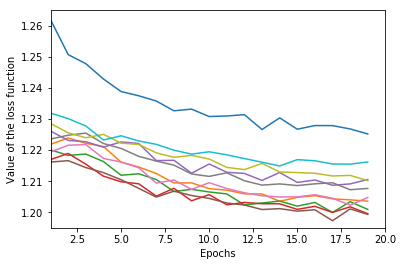

In [98]:
# Plotting of the loss function
time = np.array(range(0, number_epochs))
time = np.tile(time, (10,1))
#running_loss_plot = running_loss.data.cpu().numpy()
#running_loss_plot = np.ndarray.transpose(running_loss_plot())
plt.plot(loss_mean)
plt.ylabel('Value of the loss function')
plt.xlabel('Epochs')
plt.axis([1,20, 1.195, 1.265])
#plt.show()
plt.savefig("/home/xsong/Desktop/running.png", dpi = 300)

## Verification


During testing time, I load all ten models and keep them in a list. When making a prediction on a single instance, I apply each of the 10 models to give scores, and add the predicted scores up to make a single prediction. I do argmax over the summed scores to make the final prediction.


In [ ]:
val_x = X_torch[test_inds]
val_y = Y_torch[test_inds]

In [ ]:
models = []
best_save = [9,32,49,7,36,24,36,4,49,4]
for split in range(k_fold):
    model = Net(data)
    model.load_state_dict(torch.load("/home/xsong/Alma/Training/50_epochs_training/Model_training_01-07_" + str(split+1) + "_" + str(best_save[split]) + ".pt"))
    models.append(net)

In [ ]:
test_dataset = Data.TensorDataset(val_x, val_y)
test_loader = Data.DataLoader(test_dataset, batch_size=128, shuffle=True)  
def test(net, data):
        fit = []
        fit = torch.FloatTensor(fit).cuda()
        for i, (val_x,val_y) in enumerate(test_loader):
            val_y.requires_grad=False
            val_y = val_y[:,0] # resize the value as vector
            pred = []
            pred = torch.FloatTensor(pred).cuda()
            preds = []
            preds = torch.FloatTensor(preds).cuda()
            for model in models:
                pred = model(val_x)
                pred = pred[:,0,0,0]
                print(pred)
                preds += pred
            fit += loss_func(preds, val_y)
            print(fit)
        return fit,preds

In [ ]:
fit,preds = test(models, data)
print(fit,preds)

## Plot predictions vs data

In [ ]:
# data
x = Y_pred.flatten()
y = Y[test_inds].flatten()

# calculate R^2
r2 = scipy.stats.pearsonr(x, y)[0]**2


g = sns.jointplot(x,
                  y,
                  stat_func = None,
                  kind = 'scatter',
                  s = 5,
                  alpha = 0.1,
                  size = 5)

g.ax_joint.set_xlabel('Predicted log$_2$ Growth Rate')
g.ax_joint.set_ylabel('Measured log$_2$ Growth Rate')


text = "R$^2$ = {:0.2}".format(r2)
plt.annotate(text, xy=(-5.5, 0.95), xycoords='axes fraction')

plt.title("CNN predictions vs. test set", x = -3, y = 1.25)